## DESeq2 analysis

On cells with single guide RNAs

In [2]:
import os,sys
import numpy as np
import pandas as pd
import scanpy as sc
import pertpy

import matplotlib.pyplot as plt
import seaborn as sns


## Read data

Prepared in `*prep_DE.ipynb`. To download from Dropbox:

```bash
rclone copy "dropbox:macs_perturbseq_analysis/MACS_DE_pseudobulk_for_test.h5ad" /mnt/oak/users/emma/bin/Macs_KO_plots/
```

In [3]:
adata = sc.read_h5ad('MACS_DE_pseudobulk_for_test.h5ad')

In [7]:
adata

AnnData object with n_obs × n_vars = 5712 × 18129
    obs: 'sample_id', 'condition', 'gRNA', 'target_gene', 'n_cells', 'total_counts', 'keep_min_cells', 'keep_total_counts', 'keep_for_DE', 'keep_test_genes', 'log10_n_cells'
    var: 'gene_ids', 'gene_name'

In [6]:
adata.obs.head()

,sample_id,condition,gRNA,target_gene,n_cells,total_counts,keep_min_cells,keep_total_counts,keep_for_DE,keep_test_genes,log10_n_cells
Mac_Ctrl_A4GALT-1,Mac_Ctrl_A4GALT-1,Mac Ctrl,A4GALT-1,A4GALT,42.0,523030.0,True,True,True,True,1.623249
Mac_Ctrl_A4GALT-2,Mac_Ctrl_A4GALT-2,Mac Ctrl,A4GALT-2,A4GALT,21.0,316465.0,True,True,True,True,1.322219
Mac_Ctrl_A4GALT-3,Mac_Ctrl_A4GALT-3,Mac Ctrl,A4GALT-3,A4GALT,44.0,626700.0,True,True,True,True,1.643453
Mac_Ctrl_A4GALT-4,Mac_Ctrl_A4GALT-4,Mac Ctrl,A4GALT-4,A4GALT,45.0,667534.0,True,True,True,True,1.653213
Mac_Ctrl_AAGAB-1,Mac_Ctrl_AAGAB-1,Mac Ctrl,AAGAB-1,AAGAB,45.0,643695.0,True,True,True,True,1.653213


## Filter for DESeq2

Select one condition (we test each condition separately)

In [149]:
adata_c = adata[adata.obs['condition'] == 'Mac LPS'].copy()

Select a subset of perturbed genes to fit a DESeq2 model (corresponding to a "chunk" in [GWT analysis](https://github.com/emdann/GWT_perturbseq_analysis/blob/master/src/3_DE_analysis/run_DE_chunk.py))

In [150]:
all_targets = adata.obs['target_gene'].unique()
target_chunk = list(np.random.choice(all_targets, 50, replace=False))
if 'NTC' not in target_chunk:
    target_chunk.append('NTC')

## Add targets of interest (if not included)
np.random.seed(12323)
targets_of_interest = ['TNFAIP3', 'TLR4']
for t in targets_of_interest:
    if t not in target_chunk:
        target_chunk.append(t)

In [151]:
adata_c = adata_c[adata_c.obs.target_gene.isin(target_chunk)].copy()
adata_c

AnnData object with n_obs × n_vars = 728 × 18129
    obs: 'sample_id', 'condition', 'gRNA', 'target_gene', 'n_cells', 'total_counts', 'keep_min_cells', 'keep_effective_guides', 'keep_total_counts', 'keep_for_DE', 'keep_test_genes', 'log10_n_cells'
    var: 'gene_ids', 'gene_name'

In [152]:
adata_c.obs.groupby('target_gene').size().sort_values()

target_gene
AP1AR          3
IFI30          3
HSP90B1        3
IRF2           3
ITGAL          3
GSDMA          3
NOD1           3
LGALS9         3
NSMCE2         3
PIK3CA         3
PSCA           3
SEPHS2         3
TLR4           3
TMEM258        3
EFR3A          4
CRIPAK         4
IKBKG          4
IL2RG          4
GNAS           4
C1orf106       4
CD36           4
KIDINS220      4
KIAA1683       4
JAK2           4
NINJ1          4
NFKBIE         4
MAPKAPK2       4
PGM3           4
PTGER4         4
DRAP1          4
BUD13          4
ATP5D          4
TLR8           4
RAB5C          4
PPP2R1B        4
SGMS1          4
TAP2           4
TBK1           4
TGFBR1         4
RBX1           4
TUBA1C         4
TRAF2          4
NTC          574
dtype: int64

In [153]:
adata[adata.obs['target_gene'] == 'NTC'].obs.head()

,sample_id,condition,gRNA,target_gene,n_cells,total_counts,keep_min_cells,keep_effective_guides,keep_total_counts,keep_for_DE,keep_test_genes,log10_n_cells
Mac_Ctrl_NTC-001,Mac_Ctrl_NTC-001,Mac Ctrl,NTC-001,NTC,38.0,535083.0,True,True,True,True,True,1.579784
Mac_Ctrl_NTC-002,Mac_Ctrl_NTC-002,Mac Ctrl,NTC-002,NTC,15.0,185059.0,True,True,True,True,True,1.176091
Mac_Ctrl_NTC-003,Mac_Ctrl_NTC-003,Mac Ctrl,NTC-003,NTC,48.0,644455.0,True,True,True,True,True,1.681241
Mac_Ctrl_NTC-004,Mac_Ctrl_NTC-004,Mac Ctrl,NTC-004,NTC,39.0,547762.0,True,True,True,True,True,1.591065
Mac_Ctrl_NTC-005,Mac_Ctrl_NTC-005,Mac Ctrl,NTC-005,NTC,6.0,71497.0,True,True,True,True,True,0.778151


In [ ]:
# Subset to selected vars
selected_vars = pd.read_csv('DE_feature_selection_vars.csv')
selected_vars = selected_vars[selected_vars['highly_variable']]

adata_c = adata_c[:, adata_c.var['gene_ids'].isin(selected_vars.gene_ids)].copy()
adata_c

AnnData object with n_obs × n_vars = 728 × 12504
    obs: 'sample_id', 'condition', 'gRNA', 'target_gene', 'n_cells', 'total_counts', 'keep_min_cells', 'keep_effective_guides', 'keep_total_counts', 'keep_for_DE', 'keep_test_genes', 'log10_n_cells'
    var: 'gene_ids', 'gene_name'

## DESeq2 analysis

In [157]:
# Check data in .X contains counts
adata_c.X.data

array([ 8.,  4.,  4., ..., 74., 85., 99.])

In [158]:
# Keep measured genes with minimum counts per gene (after subsetting condition and targets)
min_counts_per_gene = 10
adata_c = adata_c[:, adata_c.X.sum(0) >= min_counts_per_gene].copy()
adata_c

AnnData object with n_obs × n_vars = 728 × 10414
    obs: 'sample_id', 'condition', 'gRNA', 'target_gene', 'n_cells', 'total_counts', 'keep_min_cells', 'keep_effective_guides', 'keep_total_counts', 'keep_for_DE', 'keep_test_genes', 'log10_n_cells'
    var: 'gene_ids', 'gene_name'

In [159]:
## Define design of test
# we use log10_n_cells as a confounder to regress out
# no need to include condition here, since we already subset to one condition at a time
design_formula = '~ log10_n_cells + target_gene'

## Fit Negative binomial GLM model on all targets at once
model = pertpy.tl.PyDESeq2(adata_c, design=design_formula)
model.fit(n_cpus = 3, quiet=False)

Fitting size factors...


Using None as control genes, passed at DeseqDataSet initialization


... done in 0.21 seconds.

Fitting dispersions...
... done in 30.89 seconds.

Fitting dispersion trend curve...
... done in 0.22 seconds.

Fitting MAP dispersions...
... done in 13.27 seconds.

Fitting LFCs...
... done in 9.24 seconds.

Calculating cook's distance...
... done in 0.19 seconds.

Replacing 3 outlier genes.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.02 seconds.



Once we fit the Generalized-linear model, we can test for differential expression for each target gene. Here we need to specify that we want to test samples from each target gene ONLY against NTCs (not compared to all other targets). 

I use the pydeseq2 implementation in `pertpy` package rather than the original one because it allows more flexibility in defining the comparisons I want to test for (using [formulaic-contrasts](https://formulaic-contrasts.readthedocs.io/en/latest/)). Comparisons here are also called "contrasts". [This tutorial](https://pertpy.readthedocs.io/en/latest/tutorials/notebooks/differential_gene_expression.html#environment-setup) has more examples on how to use contrasts in DE analysis.

In [168]:
# Example for a single target: I want to test for DE between pseudobulks with TLR4 guides vs NTCs:
contrast = model.cond(target_gene = 'TLR4') - model.cond(target_gene = 'NTC')
one_target_results_df = model.test_contrasts(contrast)
one_target_results_df.head()

Running Wald tests...


Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  1.  0.  0.  0.  0.]
           baseMean  log2FoldChange      lfcSE      stat    pvalue      padj
NOC2L      5.606364        0.239862   0.374925  0.639760  0.522328  0.848031
PLEKHN1    0.682945       -0.560895   1.400325 -0.400547  0.688754       NaN
HES4       1.489899       -1.632788   1.337557 -1.220724  0.222191  0.653004
ISG15    203.651038        0.103161   0.176017  0.586086  0.557818  0.862595
AGRN      60.487685       -0.029665   0.139369 -0.212849  0.831445  0.964209
...             ...             ...        ...       ...       ...       ...
DDX3Y     86.261413       -0.303302   0.120494 -2.517148  0.011831  0.167620
UTY       11.893059        0.002660   0.280942  0.009467  0.992446  0.999107
TTTY14     0.015724       -0.041321  22.631807 -0.001826  0.998543      

... done in 1.07 seconds.



,variable,baseMean,log_fc,lfcSE,stat,p_value,adj_p_value,contrast
0,TNFAIP2,992.003222,-0.725189,0.079818,-9.085505,1.032180e-19,9.289616e-16,None
1,CD44,1637.836377,-0.531617,0.063566,-8.363233,6.102248e-17,2.746011e-13,None
2,TNFAIP6,592.816195,-0.824660,0.103454,-7.971302,1.570109e-15,4.710327e-12,None
3,C15orf48,2188.509428,-0.437371,0.055842,-7.832329,4.789153e-15,1.077560e-11,None
4,INSIG1,282.256401,-1.682285,0.216825,-7.758727,8.578590e-15,1.544146e-11,None


Some sanity checks. Let's look at the p-value histogram.

(array([1860., 1036.,  937.,  862.,  807.,  826.,  796.,  843.,  908.,
        1538.]),
 array([1.03217960e-19, 9.99969186e-02, 1.99993837e-01, 2.99990756e-01,
        3.99987674e-01, 4.99984593e-01, 5.99981512e-01, 6.99978430e-01,
        7.99975349e-01, 8.99972267e-01, 9.99969186e-01]),
 <BarContainer object of 10 artists>)

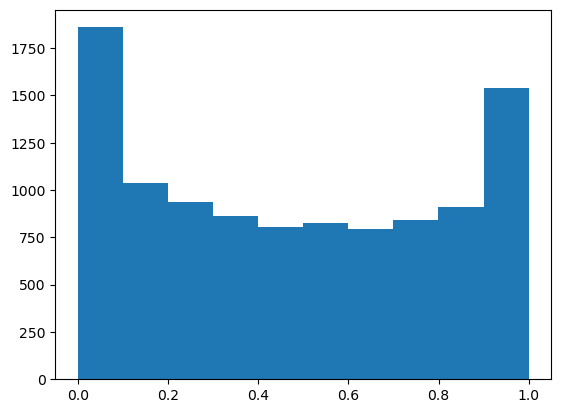

In [170]:
plt.hist(one_target_results_df.p_value)

This looks as expected. The peak at 1 mostly corresponds to genes that have a very low mean expression, which are filtered in post-processing by [independent filtering](https://bioconductor.org/packages/release/bioc/vignettes/DESeq2/inst/doc/DESeq2.html#indfilt) (you can see their `adj_p_value` is set to Nan).

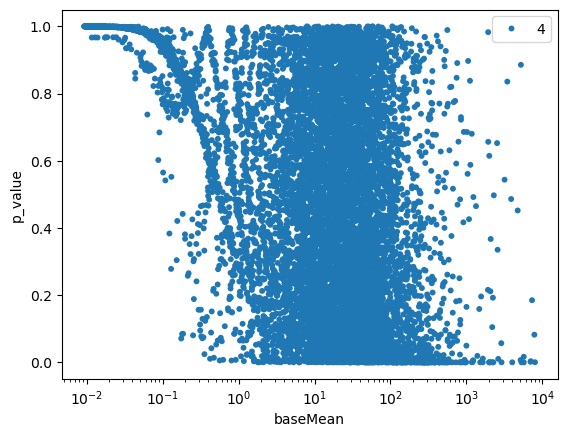

In [176]:
sns.scatterplot(data=one_target_results_df, x='baseMean', y='p_value', edgecolor='none', size=4);
plt.xscale('log')

Do we see the on-target effect?

In [182]:
one_target_results_df[one_target_results_df.variable == 'TLR4']

,variable,baseMean,log_fc,lfcSE,stat,p_value,adj_p_value,contrast
131,TLR4,143.444636,-0.522756,0.130621,-4.002083,0.000063,0.004266,None


Check top DE genes 

In [183]:
one_target_results_df.sort_values('adj_p_value')[0:10]

,variable,baseMean,log_fc,lfcSE,stat,p_value,adj_p_value,contrast
0,TNFAIP2,992.003222,-0.725189,0.079818,-9.085505,1.032180e-19,9.289616e-16,None
1,CD44,1637.836377,-0.531617,0.063566,-8.363233,6.102248e-17,2.746011e-13,None
2,TNFAIP6,592.816195,-0.824660,0.103454,-7.971302,1.570109e-15,4.710327e-12,None
3,C15orf48,2188.509428,-0.437371,0.055842,-7.832329,4.789153e-15,1.077560e-11,None
4,INSIG1,282.256401,-1.682285,0.216825,-7.758727,8.578590e-15,1.544146e-11,None
5,IL1B,2900.232179,-1.268459,0.166140,-7.634890,2.260130e-14,2.995288e-11,None
6,TRAF1,649.896676,-0.905172,0.118618,-7.630985,2.329668e-14,2.995288e-11,None
7,BASP1,437.531655,-0.735049,0.096568,-7.611703,2.705079e-14,3.043214e-11,None
9,SLC39A8,484.262107,-0.958269,0.126705,-7.562985,3.939225e-14,3.545302e-11,None
8,SERPINB9,356.482340,-1.045468,0.138172,-7.566396,3.837210e-14,3.545302e-11,None


In [ ]:
# Example for all targets in chunk
control_level = 'NTC'
all_targets = adata_c.obs['target_gene'].unique().tolist()
all_targets.remove(control_level)
# Define a dictionary of contrasts
contrasts = {t:(model.cond(target_gene = t) - model.cond(target_gene = control_level)) for t in all_targets}

# Test all contrasts (this prints a lot of output - I've deleted it here)
res_df = model.test_contrasts(contrasts)

In [ ]:
# Here the tested target is specified in "contrast" column
res_df

,variable,baseMean,log_fc,lfcSE,stat,p_value,adj_p_value,contrast
0,SDC4,134.218478,0.418268,0.098846,4.231508,0.000023,0.241716,AP1AR
1,KDM4B,26.344490,-0.766020,0.191670,-3.996553,0.000064,0.334630,AP1AR
2,IER2,28.332765,0.740633,0.198618,3.728936,0.000192,0.530225,AP1AR
3,SEC11A,107.360314,0.273349,0.073592,3.714411,0.000204,0.530225,AP1AR
4,SLC25A37,25.110195,-0.920315,0.260828,-3.528435,0.000418,0.760492,AP1AR
...,...,...,...,...,...,...,...,...
10409,GTPBP2,36.973368,-0.000059,0.120282,-0.000488,0.999610,0.999864,TUBA1C
10410,DOP1B,7.524037,0.000112,0.271689,0.000411,0.999672,0.999864,TUBA1C
10411,ZNF16,4.095704,0.000027,0.379429,0.000070,0.999944,0.999963,TUBA1C
10412,SAT1,610.918893,-0.000003,0.061580,-0.000046,0.999963,0.999963,TUBA1C


## Test all targets in all conditions

In [ ]:
# Split all targets into chunks of 50
all_targets = [t for t in adata.obs['target_gene'].unique() if t != 'NTC']
chunk_size = 50
target_chunks = [list(all_targets[i:i+chunk_size]) for i in range(0, len(all_targets), chunk_size)]

print(f"Number of chunks: {len(target_chunks)}")
print(f"Chunk sizes (excl. NTC): {[len(c) for c in target_chunks]}")

# Load selected vars once
selected_vars = pd.read_csv('DE_feature_selection_vars.csv')
selected_vars = selected_vars[selected_vars['highly_variable']]

# Fit one model per condition per chunk
models = {}
for c in ['Mac Ctrl', 'Mac LPS']:
    for i, chunk in enumerate(target_chunks):
        chunk_with_ntc = chunk + ['NTC']
        print(f"Fitting model for {c}, chunk {i+1}/{len(target_chunks)} ({len(chunk)} targets + NTC)...")
        
        adata_c = adata[adata.obs['condition'] == c].copy()
        adata_c = adata_c[adata_c.obs.target_gene.isin(chunk_with_ntc)].copy()
        adata_c = adata_c[:, adata_c.var['gene_ids'].isin(selected_vars.gene_ids)].copy()
        
        min_counts_per_gene = 10
        adata_c = adata_c[:, adata_c.X.sum(0) >= min_counts_per_gene].copy()
        adata_c.obs['log10_n_cells'] = np.log10(adata_c.obs['n_cells'])
        
        design_formula = '~ log10_n_cells + target_gene'
        model = pertpy.tl.PyDESeq2(adata_c, design=design_formula)
        model.fit(n_cpus=3, quiet=True)
        models[(c, i)] = model
        print(f"  Done. adata shape: {adata_c.shape}")

Number of chunks: 12
Chunk sizes (excl. NTC): [50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 18]
Fitting model for Mac Ctrl, chunk 1/12 (50 targets + NTC)...


Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.



  Done. adata shape: (774, 10407)
Fitting model for Mac Ctrl, chunk 2/12 (50 targets + NTC)...


Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.



  Done. adata shape: (771, 10403)
Fitting model for Mac Ctrl, chunk 3/12 (50 targets + NTC)...


Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.



  Done. adata shape: (768, 10401)
Fitting model for Mac Ctrl, chunk 4/12 (50 targets + NTC)...


Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.



  Done. adata shape: (820, 10416)
Fitting model for Mac Ctrl, chunk 5/12 (50 targets + NTC)...


Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.



  Done. adata shape: (768, 10393)
Fitting model for Mac Ctrl, chunk 6/12 (50 targets + NTC)...


Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.02 seconds.



  Done. adata shape: (771, 10414)
Fitting model for Mac Ctrl, chunk 7/12 (50 targets + NTC)...


Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.



  Done. adata shape: (767, 10403)
Fitting model for Mac Ctrl, chunk 8/12 (50 targets + NTC)...


Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.02 seconds.



  Done. adata shape: (767, 10412)
Fitting model for Mac Ctrl, chunk 9/12 (50 targets + NTC)...


Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.



  Done. adata shape: (767, 10399)
Fitting model for Mac Ctrl, chunk 10/12 (50 targets + NTC)...


Fitting dispersions...
... done in 0.32 seconds.

Fitting MAP dispersions...
... done in 0.02 seconds.

Fitting LFCs...
... done in 0.02 seconds.



  Done. adata shape: (771, 10410)
Fitting model for Mac Ctrl, chunk 11/12 (50 targets + NTC)...


Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.02 seconds.



  Done. adata shape: (768, 10423)
Fitting model for Mac Ctrl, chunk 12/12 (18 targets + NTC)...


Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.



  Done. adata shape: (645, 10356)
Fitting model for Mac LPS, chunk 1/12 (50 targets + NTC)...


Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.



  Done. adata shape: (775, 10418)
Fitting model for Mac LPS, chunk 2/12 (50 targets + NTC)...


Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.



  Done. adata shape: (773, 10439)
Fitting model for Mac LPS, chunk 3/12 (50 targets + NTC)...


Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.



  Done. adata shape: (769, 10426)
Fitting model for Mac LPS, chunk 4/12 (50 targets + NTC)...


Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.



  Done. adata shape: (818, 10448)
Fitting model for Mac LPS, chunk 5/12 (50 targets + NTC)...


Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.02 seconds.



  Done. adata shape: (769, 10408)
Fitting model for Mac LPS, chunk 6/12 (50 targets + NTC)...


Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.



  Done. adata shape: (772, 10436)
Fitting model for Mac LPS, chunk 7/12 (50 targets + NTC)...


Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.



  Done. adata shape: (772, 10425)
Fitting model for Mac LPS, chunk 8/12 (50 targets + NTC)...


Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.02 seconds.



  Done. adata shape: (767, 10443)
Fitting model for Mac LPS, chunk 9/12 (50 targets + NTC)...


Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.02 seconds.



  Done. adata shape: (769, 10428)
Fitting model for Mac LPS, chunk 10/12 (50 targets + NTC)...


Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.



  Done. adata shape: (773, 10423)
Fitting model for Mac LPS, chunk 11/12 (50 targets + NTC)...


Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.



  Done. adata shape: (769, 10426)
Fitting model for Mac LPS, chunk 12/12 (18 targets + NTC)...
  Done. adata shape: (646, 10365)


Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.



In [14]:
models.keys()

dict_keys([('Mac Ctrl', 0), ('Mac Ctrl', 1), ('Mac Ctrl', 2), ('Mac Ctrl', 3), ('Mac Ctrl', 4), ('Mac Ctrl', 5), ('Mac Ctrl', 6), ('Mac Ctrl', 7), ('Mac Ctrl', 8), ('Mac Ctrl', 9), ('Mac Ctrl', 10), ('Mac Ctrl', 11), ('Mac LPS', 0), ('Mac LPS', 1), ('Mac LPS', 2), ('Mac LPS', 3), ('Mac LPS', 4), ('Mac LPS', 5), ('Mac LPS', 6), ('Mac LPS', 7), ('Mac LPS', 8), ('Mac LPS', 9), ('Mac LPS', 10), ('Mac LPS', 11)])

In [18]:
# Test each target vs NTC for each model
all_results = []
for (c, i), model in models.items():
    cond_label = c.split(' ')[1]
    outfile = f"results/DESeq2_singlets.chunk{i}.{cond_label}.csv"
    if not os.path.exists(outfile):
        chunk_targets = target_chunks[i]  # targets without NTC
        print(f"Testing {len(chunk_targets)} targets for {c}, chunk {i+1}...")
        contrasts = {t: (model.cond(target_gene=t) - model.cond(target_gene='NTC')) for t in chunk_targets}
        res_df = model.test_contrasts(contrasts)
        res_df['condition'] = c
        res_df['chunk'] = i
        all_results.append(res_df)
        # Save per chunk
        cond_label = c.split(' ')[1]
        res_df.to_csv(outfile, index=False)
        print(f"  Saved {outfile}")
        all_results.append(res_df)
    else:
        print(f"  File {outfile} found - skipping")
        res_df = pd.read_csv(outfile)
        all_results.append(res_df[['variable', 'baseMean', 'log_fc', 'p_value', 'adj_p_value', 'contrast', 'condition']])

results_df = pd.concat(all_results, ignore_index=True)
print(f"Total results: {results_df.shape}")
results_df

  File results/DESeq2_singlets.chunk0.Ctrl.csv found - skipping
  File results/DESeq2_singlets.chunk1.Ctrl.csv found - skipping
  File results/DESeq2_singlets.chunk2.Ctrl.csv found - skipping
  File results/DESeq2_singlets.chunk3.Ctrl.csv found - skipping
  File results/DESeq2_singlets.chunk4.Ctrl.csv found - skipping
  File results/DESeq2_singlets.chunk5.Ctrl.csv found - skipping
  File results/DESeq2_singlets.chunk6.Ctrl.csv found - skipping
  File results/DESeq2_singlets.chunk7.Ctrl.csv found - skipping
  File results/DESeq2_singlets.chunk8.Ctrl.csv found - skipping
  File results/DESeq2_singlets.chunk9.Ctrl.csv found - skipping
  File results/DESeq2_singlets.chunk10.Ctrl.csv found - skipping
  File results/DESeq2_singlets.chunk11.Ctrl.csv found - skipping
  File results/DESeq2_singlets.chunk0.LPS.csv found - skipping
  File results/DESeq2_singlets.chunk1.LPS.csv found - skipping
  File results/DESeq2_singlets.chunk2.LPS.csv found - skipping
  File results/DESeq2_singlets.chunk3.LPS

,variable,baseMean,log_fc,p_value,adj_p_value,contrast,condition
0,RBM19,24.950018,-0.692646,0.000147,0.763225,A4GALT,Mac Ctrl
1,SOCS1,3.294059,1.486906,0.000340,0.763225,A4GALT,Mac Ctrl
2,PLCB3,24.289618,-0.659496,0.000390,0.763225,A4GALT,Mac Ctrl
3,CCNDBP1,49.541595,0.334342,0.000416,0.763225,A4GALT,Mac Ctrl
4,NUPR1,609.686895,0.297589,0.000466,0.763225,A4GALT,Mac Ctrl
...,...,...,...,...,...,...,...
11831423,TNIK,68.848548,-0.000043,0.999705,0.999866,ZNRD1,Mac LPS
11831424,ORAI1,82.897351,0.000028,0.999770,0.999866,ZNRD1,Mac LPS
11831425,ATG4B,41.861888,-0.000011,0.999926,0.999926,ZNRD1,Mac LPS
11831426,JCHAIN,0.109850,-0.329652,NaN,NaN,ZNRD1,Mac LPS


In [19]:
# Save results_df as a pickle DataFrame and gzipped CSV
# results_df.to_pickle("results/DESeq2_all_results.pkl")
results_df.to_csv("results/DESeq2_all_results.csv.gz", index=False, compression="gzip")